In [1]:
!gdown https://drive.google.com/uc?id=1o7Go9ccHwxFbZLMAOJeyvTJBUwrJ9TO1
!mkdir object_det_samples
!unzip -q object_det_samples.zip -d object_det_samples

Downloading...
From: https://drive.google.com/uc?id=1o7Go9ccHwxFbZLMAOJeyvTJBUwrJ9TO1
To: /content/object_det_samples.zip
100% 46.7M/46.7M [00:00<00:00, 131MB/s]


In [2]:
!pip install albumentations==0.4.6 -q

import pandas as pd
import xml, sys, os
import numpy as np 
import random, cv2
from glob import glob
import matplotlib.pyplot as plt
from xml.etree import ElementTree

import albumentations as AA
from albumentations.pytorch.transforms import ToTensorV2

import torch 
from torch.utils.data import Dataset,DataLoader

     |████████████████████████████████| 117 kB 4.3 MB/s 
     |████████████████████████████████| 948 kB 11.0 MB/s 


In [3]:
df = pd.read_csv('/content/object_det_samples/df.csv')
df.head()

,image_id,object,image_width,image_height,image_depth,xmin,ymin,width,height,x_center,y_center,area
0,1,human,4032,2696,3,2369,1320,746,1357,1557.5,1338.5,1012322
1,1,car,4032,2696,3,2856,980,1176,573,2016.0,776.5,673848
2,1,human,4032,2696,3,751,1052,171,330,461.0,691.0,56430
3,1,bike,4032,2696,3,679,1193,304,255,491.5,724.0,77520
4,1,human,4032,2696,3,915,1081,66,90,490.5,585.5,5940


In [4]:
print(df.object.value_counts())

cls = {
    'human':1,                    
    'car'  :2,                
    'bike' :3,                     
    'bus'  :4,  
}
df['labels'] = df.object.map(cls) 
df.head()

human    213
car       83
bike      21
bus        4
Name: object, dtype: int64


,image_id,object,image_width,image_height,image_depth,xmin,ymin,width,height,x_center,y_center,area,labels
0,1,human,4032,2696,3,2369,1320,746,1357,1557.5,1338.5,1012322,1
1,1,car,4032,2696,3,2856,980,1176,573,2016.0,776.5,673848,2
2,1,human,4032,2696,3,751,1052,171,330,461.0,691.0,56430,1
3,1,bike,4032,2696,3,679,1193,304,255,491.5,724.0,77520,3
4,1,human,4032,2696,3,915,1081,66,90,490.5,585.5,5940,1


In [5]:
IMG_SIZE = 1024

def get_transforms():
    return AA.Compose(
        [
            AA.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=AA.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

class DatasetRetriever(Dataset):
    def __init__(self, main_df, image_ids, transforms):
        super().__init__()
        self.image_ids = image_ids
        self.main_df = main_df
        self.transforms = transforms
        self.size_limit = 15

    def __getitem__(self, index: int):
        image_id = self.image_ids[index] 

        it = 0
        while True: # It's possible that in mosaic, all 4 samples doesn't contian any bbox
            image, boxes = self.load_mosaic_image_and_boxes(index)
            if len(boxes) > 0:
                break
            it += 1
            if it == 50: print('No BBOX In Mosaic')
   
        #class 
        labels = torch.tensor(boxes[:, 4], dtype=torch.int64) # for multi-class 
        
        # remove class label indices
        boxes = boxes[:, :4]
        
        target = {}
        target['boxes'] = boxes
        target['cls']   = labels
        target['image_id'] = torch.tensor([index])     
        
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image' : image,
                    'bboxes': target['boxes'],
                    'labels': target['cls'] 
                })
                
                #assert len(sample['bboxes']) == target['cls'].shape[0], 'not equal!'
                if len(sample['bboxes']) > 0:
                    # image
                    image = sample['image']
                    
                    # box
                    target['boxes'] = torch.tensor(sample['bboxes'])
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    
                    # label
                    target['cls'] = torch.stack(sample['labels'])
                    break
                    
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index, size = 768):
        image_id = self.image_ids[index]
        image  = cv2.imread(f'/content/object_det_samples/{image_id}.jpg')[:,:,::-1]
    
        records = self.main_df[self.main_df['image_id'] == image_id]
        boxes   = records[['xmin', 'ymin', 'width', 'height', 'labels']].values
        
        # as pascal voc format
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # width  to xmax - by: xmin + xmax 
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # height to ymax - by: ymin + ymax
        
        #resize images and boxes
        if size != 1:
            f_y = size/image.shape[0]
            f_x = size/image.shape[1]
            
            image = cv2.resize(image, (size, size))
        
            boxes[:, 0] = boxes[:, 0]*f_x
            boxes[:, 2] = boxes[:, 2]*f_x
            boxes[:, 1] = boxes[:, 1]*f_y
            boxes[:, 3] = boxes[:, 3]*f_y
        
        return image, boxes 
   
    
    def load_mosaic_image_and_boxes(self, index, s=512, 
                                    minfrac=0.25, maxfrac=0.75):
        self.mosaic_size = s
        xc, yc = np.random.randint(s * minfrac, s * maxfrac, (2,))

        # random other 3 sample (could be the same too...)
        indices = [index] + random.sample(range(len(self.image_ids)), 3) 

        mosaic_image = np.zeros((s, s, 3), dtype=np.float32)
        final_boxes  = []
        final_labels = []
        
        for i, index in enumerate(indices):
            image, boxes = self.load_image_and_boxes(index, size=s)
            if i == 0:    # top left
                x1a, y1a, x2a, y2a =  0,  0, xc, yc
                x1b, y1b, x2b, y2b = s - xc, s - yc, s, s # from bottom right
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, 0, s , yc
                x1b, y1b, x2b, y2b = 0, s - yc, s - xc, s # from bottom left
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = 0, yc, xc, s
                x1b, y1b, x2b, y2b = s - xc, 0, s, s-yc   # from top right
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc,  s, s
                x1b, y1b, x2b, y2b = 0, 0, s-xc, s-yc    # from top left

            # calculate and apply box offsets due to replacement            
            offset_x = x1a - x1b
            offset_y = y1a - y1b
            
            boxes[:, 0] += offset_x
            boxes[:, 1] += offset_y
            boxes[:, 2] += offset_x
            boxes[:, 3] += offset_y
            
            # cut image, save boxes
            mosaic_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            final_boxes.append(boxes)

        # collect boxes
        final_boxes  = np.vstack(final_boxes)

        # clip boxes to the image area
        final_boxes[:, 0:] = np.clip(final_boxes[:, 0:], 0, s).astype(np.int32)
        w = (final_boxes[:,2] - final_boxes[:,0])
        h = (final_boxes[:,3] - final_boxes[:,1])
        
        # discard boxes where w or h <10
        final_boxes = final_boxes[(w>=self.size_limit) & (h>=self.size_limit)]

        return mosaic_image, final_boxes 

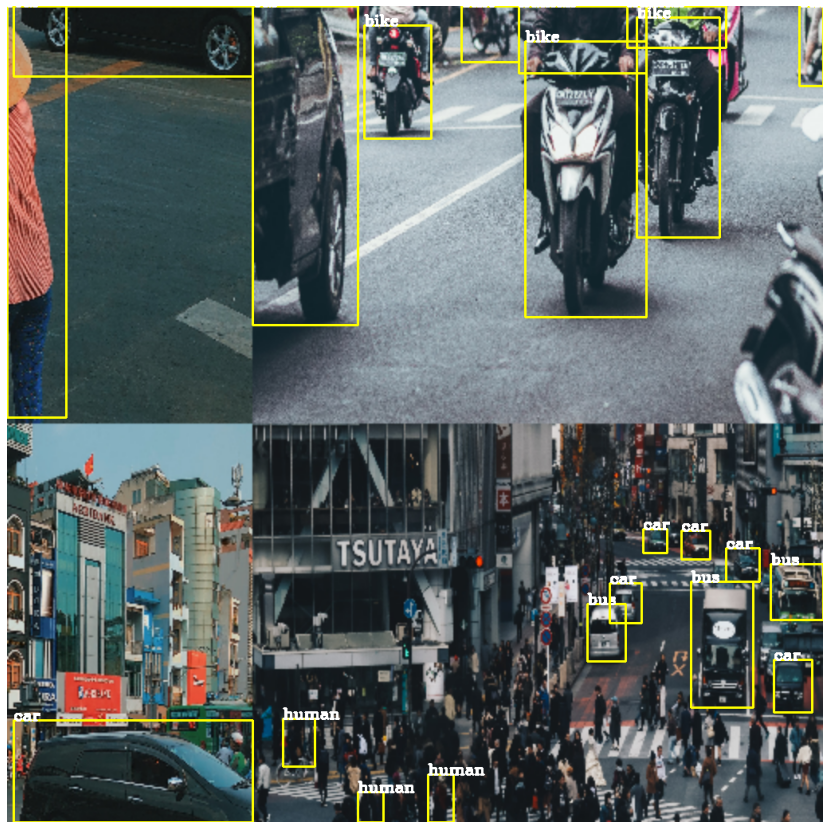

In [10]:
train_dataset = DatasetRetriever(
    image_ids=df.image_id.unique(),
    main_df=df,
    transforms=get_transforms()
)

image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)
numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
for box, label in zip(boxes, target['cls']):
    # draw the rectangle 
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (255, 255, 0), 2)
    
    # find word by mapping with dictionary item and put it on image using cv2.putText
    word = list(cls.keys())[list(cls.values()).index(int(label))]
    cv2.putText(numpy_image, word, (box[1], box[0]), 
                cv2.FONT_HERSHEY_COMPLEX, 
                0.6, (255,255,255), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image.astype(np.uint8));